In [22]:
import matplotlib.pyplot as plt
from time import time
from simfunctions import *

import matplotlib as mpl



# Take colors at regular intervals spanning the colormap.
colors = mpl.colormaps['Dark2'].colors

# SI Model

$$ S + I \to I + I, c_1x_Sx_I $$
$$ S \to I, c_2x_S $$
with parameters $c_1 = 0.008, c_2=0.1.$


In [23]:
def rate1(X):
    rate = 0.008*X[0]*X[1]
    if rate > 0:
        return rate
    else:
        return 0

def rate2(X):
    rate = 0.1*X[0]
    if rate > 0:
        return rate
    else:
        return 0
    
def jac(X):
    return np.array([[0.008*X[1], 0.008*X[0]], [0.1, 0]])

# Example usage:
drift = [rate1, rate2]
S_matrix = np.array([[-1, 1], [-1, 1]])  # Stoichiometry matrix
c = np.array([1,1])  # Reaction rates
X0 = np.array([90, 10])  # Initial state
T = 3  # Total time

## Tau-Leaping

In [24]:
tau = 0.3  # Leap size

n_runs = 1000
runs = []

for run in range(n_runs):
    if 100*run/n_runs % 10 == 0:
        print(100*run/n_runs, '% simulations completed')
    X = None
    while X is None:
        X, t_tau = tau_leaping(drift, S_matrix, c, X0, T, tau)
    runs.append(X)
    
print('Number of steps: ', len(X))

0.0 % simulations completed
10.0 % simulations completed
20.0 % simulations completed
30.0 % simulations completed
40.0 % simulations completed
50.0 % simulations completed
60.0 % simulations completed


70.0 % simulations completed
80.0 % simulations completed
90.0 % simulations completed
Number of steps:  11


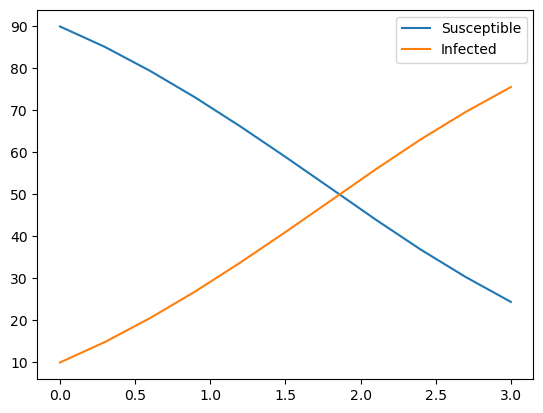

In [25]:
Xs = np.mean(np.array(runs)[:,:,0], axis=0)
Xi = np.mean(np.array(runs)[:,:,1], axis=0)

plt.plot(t_tau, Xs, label='Susceptible')
plt.plot(t_tau, Xi, label='Infected')
plt.legend()

## Mean-field

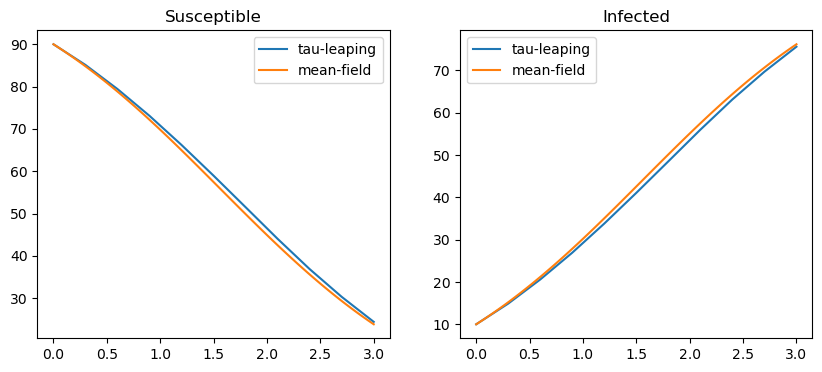

In [26]:
tmf = np.linspace(0,T, 100)
Xmf = mean_field(drift,S_matrix,c,X0,tmf)

fig, axs = plt.subplots(1,2, figsize=(10,4))

axs[0].plot(t_tau, Xs, label='tau-leaping')
axs[0].plot(tmf, Xmf[:,0], label='mean-field')
axs[0].set_title('Susceptible')
axs[0].legend()

axs[1].plot(t_tau, Xi, label='tau-leaping')
axs[1].plot(tmf, Xmf[:,1], label='mean-field')
axs[1].set_title('Infected')
axs[1].legend()

## SOGA - Gaussian Approximation

In [27]:
from sogaPreprocessor import *
from producecfg import *
from libSOGA import *

compiledFile=compile2SOGA('../programs/SOGA/SSA/SI5mom1.soga')
cfg = produce_cfg(compiledFile)
start = time()
output_dist = start_SOGA(cfg)
end = time()

print('Computed in {}s'.format(np.round(end-start,3)))

ANTLR runtime and generated code versions disagree: 4.13.1!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.1!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.1!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.1!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.1!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.1!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.1!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.1!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.1!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.1!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.1!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.1!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.1!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.1!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.1!=4.

In [28]:
t = len(t_tau)

xs = np.zeros(t)
xi = np.zeros(t)
stds = np.zeros(t)
stdi = np.zeros(t)

for i in range(t):
    idxs = output_dist.var_list.index('susceptible[{}]'.format(i))
    idxi = output_dist.var_list.index('infected[{}]'.format(i))
    xs[i] = output_dist.gm.mean()[idxs]
    stds[i] = np.sqrt(output_dist.gm.cov()[idxs,idxs])
    xi[i] = output_dist.gm.mean()[idxi]
    stdi[i] = np.sqrt(output_dist.gm.cov()[idxi,idxi])

Text(0, 0.5, 'Number of individuals')

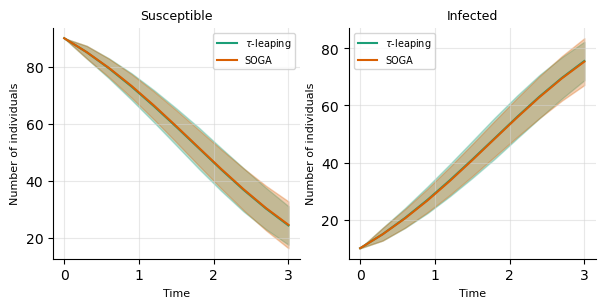

In [29]:
fig, axs = plt.subplots(1,2, figsize=(7,3))

stdS = np.std(np.array(runs)[:,:,0], axis=0)
stdI = np.std(np.array(runs)[:,:,1], axis=0)

axs[0].plot(t_tau, Xs, label=r'$\tau$-leaping', color=colors[0])
axs[0].fill_between(t_tau, Xs-stdS, Xs+stdS ,alpha=0.3, color=colors[0])
#axs[0].plot(tmf, Xmf[:,0], label='mean-field', color='green')
axs[0].plot(t_tau, xs, label='SOGA', color=colors[1])
axs[0].fill_between(t_tau, xs-stds, xs+stds ,alpha=0.3, color=colors[1])
axs[0].set_title('Susceptible', fontsize=9)
#axs[0].axhline(0)
axs[0].legend(fontsize = 7)
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)
axs[0].grid(color='lightgray', alpha=0.5, zorder=1)
axs[0].set_xlabel('Time', fontsize=8)
axs[0].set_ylabel('Number of individuals', fontsize=8)

axs[1].plot(t_tau, Xi, label=r'$\tau$-leaping', color = colors[0])
axs[1].fill_between(t_tau, Xi-stdI, Xi+stdI, alpha=0.3, color=colors[0])
#axs[1].plot(tmf, Xmf[:,1], label='mean-field', color='green')
axs[1].plot(t_tau, xi, label='SOGA', color=colors[1])
axs[1].fill_between(t_tau, xi-stdi, xi+stdi ,alpha=0.3, color=colors[1])
axs[1].set_title('Infected', fontsize=9)
#axs[1].axhline(0)
axs[1].legend(fontsize = 7)
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].grid(color='lightgray', alpha=0.5, zorder=1)
axs[1].set_xlabel('Time', fontsize=8)
axs[1].set_ylabel('Number of individuals', fontsize=8)

## SOGA - Neural Gaussian Approximation

In [30]:
from sogaPreprocessor import *
from producecfg import *
from libSOGA import *

compiledFile=compile2SOGA('../programs/SOGA/SSA/SI5mom1.soga')
cfg = produce_cfg(compiledFile)
start = time()
output_dist = start_SOGA(cfg, pruning='ranking')
end = time()

print('Computed in {}s'.format(np.round(end-start,3)))

ANTLR runtime and generated code versions disagree: 4.13.1!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.1!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.1!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.1!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.1!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.1!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.1!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.1!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.1!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.1!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.1!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.1!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.1!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.1!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.1!=4.

In [31]:
'''
t = len(t_tau)

xs = np.zeros(t)
xi = np.zeros(t)
stds = np.zeros(t)
stdi = np.zeros(t)

for i in range(t):
    idxs = output_dist.var_list.index('susceptible[{}]'.format(i))
    idxi = output_dist.var_list.index('infected[{}]'.format(i))
    xs[i] = output_dist.gm.mean()[idxs]
    stds[i] = np.sqrt(output_dist.gm.cov()[idxs,idxs])
    xi[i] = output_dist.gm.mean()[idxi]
    stdi[i] = np.sqrt(output_dist.gm.cov()[idxi,idxi])
'''

"\nt = len(t_tau)\n\nxs = np.zeros(t)\nxi = np.zeros(t)\nstds = np.zeros(t)\nstdi = np.zeros(t)\n\nfor i in range(t):\n    idxs = output_dist.var_list.index('susceptible[{}]'.format(i))\n    idxi = output_dist.var_list.index('infected[{}]'.format(i))\n    xs[i] = output_dist.gm.mean()[idxs]\n    stds[i] = np.sqrt(output_dist.gm.cov()[idxs,idxs])\n    xi[i] = output_dist.gm.mean()[idxi]\n    stdi[i] = np.sqrt(output_dist.gm.cov()[idxi,idxi])\n"

In [32]:
'''
fig, axs = plt.subplots(1,2, figsize=(10,4))

axs[0].plot(t_tau, Xs, label='tau-leaping')
axs[0].plot(tmf, Xmf[:,0], label='mean-field', color='green')
axs[0].plot(t_tau, xs, label='SOGA', color='orange')
axs[0].fill_between(t_tau, xs-stds, xs+stds ,alpha=0.3, color='orange')
axs[0].set_title('Susceptible')
#axs[0].axhline(0)
axs[0].legend()

axs[1].plot(t_tau, Xi, label='tau-leaping')
axs[1].plot(tmf, Xmf[:,1], label='mean-field', color='green')
axs[1].plot(t_tau, xi, label='SOGA', color='orange')
axs[1].fill_between(t_tau, xi-stdi, xi+stdi ,alpha=0.3, color='orange')
axs[1].set_title('Infected')
#axs[1].axhline(0)
axs[1].legend()
'''

"\nfig, axs = plt.subplots(1,2, figsize=(10,4))\n\naxs[0].plot(t_tau, Xs, label='tau-leaping')\naxs[0].plot(tmf, Xmf[:,0], label='mean-field', color='green')\naxs[0].plot(t_tau, xs, label='SOGA', color='orange')\naxs[0].fill_between(t_tau, xs-stds, xs+stds ,alpha=0.3, color='orange')\naxs[0].set_title('Susceptible')\n#axs[0].axhline(0)\naxs[0].legend()\n\naxs[1].plot(t_tau, Xi, label='tau-leaping')\naxs[1].plot(tmf, Xmf[:,1], label='mean-field', color='green')\naxs[1].plot(t_tau, xi, label='SOGA', color='orange')\naxs[1].fill_between(t_tau, xi-stdi, xi+stdi ,alpha=0.3, color='orange')\naxs[1].set_title('Infected')\n#axs[1].axhline(0)\naxs[1].legend()\n"

## SOGA - Discrete Approximation

In [33]:
'''
# Tau-leaping
S_matrix = np.array([[-1, 1], [-1, 1]])  # Stoichiometry matrix
c = np.array([0.008, 0.1])  # Reaction rates
X0 = np.array([90, 10])  # Initial state
T = 5  # Total time
tau = 0.1  # Leap size

n_runs = 1000
runs = []

for _ in range(n_runs):
    X, t_tau = tau_leaping(drift, S_matrix, c, X0, T, tau)
    runs.append(X)
    
Xs = np.mean(np.array(runs)[:,:,0], axis=0)
Xi = np.mean(np.array(runs)[:,:,1], axis=0)
    
# SOGA

compiledFile=compile2SOGA('../programs/SOGA/SSA/SIdisc.soga')
cfg = produce_cfg(compiledFile)
start = time()
output_dist = start_SOGA(cfg, pruning='ranking')
end = time()

print('Computed in {}s'.format(np.round(end-start,3)))

t = len(t_tau)
xs = np.zeros(t)
xi = np.zeros(t)
stds = np.zeros(t)
stdi = np.zeros(t)

for i in range(t):
    idxs = output_dist.var_list.index('susceptible[{}]'.format(i))
    idxi = output_dist.var_list.index('infected[{}]'.format(i))
    xs[i] = output_dist.gm.mean()[idxs]
    stds[i] = np.sqrt(output_dist.gm.cov()[idxs,idxs])
    xi[i] = output_dist.gm.mean()[idxi]
    stdi[i] = np.sqrt(output_dist.gm.cov()[idxi,idxi])
'''

"\n# Tau-leaping\nS_matrix = np.array([[-1, 1], [-1, 1]])  # Stoichiometry matrix\nc = np.array([0.008, 0.1])  # Reaction rates\nX0 = np.array([90, 10])  # Initial state\nT = 5  # Total time\ntau = 0.1  # Leap size\n\nn_runs = 1000\nruns = []\n\nfor _ in range(n_runs):\n    X, t_tau = tau_leaping(drift, S_matrix, c, X0, T, tau)\n    runs.append(X)\n    \nXs = np.mean(np.array(runs)[:,:,0], axis=0)\nXi = np.mean(np.array(runs)[:,:,1], axis=0)\n    \n# SOGA\n\ncompiledFile=compile2SOGA('../programs/SOGA/SSA/SIdisc.soga')\ncfg = produce_cfg(compiledFile)\nstart = time()\noutput_dist = start_SOGA(cfg, pruning='ranking')\nend = time()\n\nprint('Computed in {}s'.format(np.round(end-start,3)))\n\nt = len(t_tau)\nxs = np.zeros(t)\nxi = np.zeros(t)\nstds = np.zeros(t)\nstdi = np.zeros(t)\n\nfor i in range(t):\n    idxs = output_dist.var_list.index('susceptible[{}]'.format(i))\n    idxi = output_dist.var_list.index('infected[{}]'.format(i))\n    xs[i] = output_dist.gm.mean()[idxs]\n    stds[i] =

In [34]:
# Plot
'''
fig, axs = plt.subplots(1,2, figsize=(10,4))

axs[0].plot(t_tau, Xs, label='tau-leaping')
axs[0].plot(t_tau, xs, label='SOGA', color='orange')
axs[0].fill_between(t_tau, xs-stds, xs+stds ,alpha=0.3, color='orange')
axs[0].set_title('Susceptible')
axs[0].legend()

axs[1].plot(t_tau, Xi, label='tau-leaping')
axs[1].plot(t_tau, xi, label='SOGA')
axs[1].fill_between(t_tau, xi-stdi, xi+stdi ,alpha=0.3, color='orange')
axs[1].set_title('Infected')
axs[1].legend()
'''

"\nfig, axs = plt.subplots(1,2, figsize=(10,4))\n\naxs[0].plot(t_tau, Xs, label='tau-leaping')\naxs[0].plot(t_tau, xs, label='SOGA', color='orange')\naxs[0].fill_between(t_tau, xs-stds, xs+stds ,alpha=0.3, color='orange')\naxs[0].set_title('Susceptible')\naxs[0].legend()\n\naxs[1].plot(t_tau, Xi, label='tau-leaping')\naxs[1].plot(t_tau, xi, label='SOGA')\naxs[1].fill_between(t_tau, xi-stdi, xi+stdi ,alpha=0.3, color='orange')\naxs[1].set_title('Infected')\naxs[1].legend()\n"

# Chemical Langevin

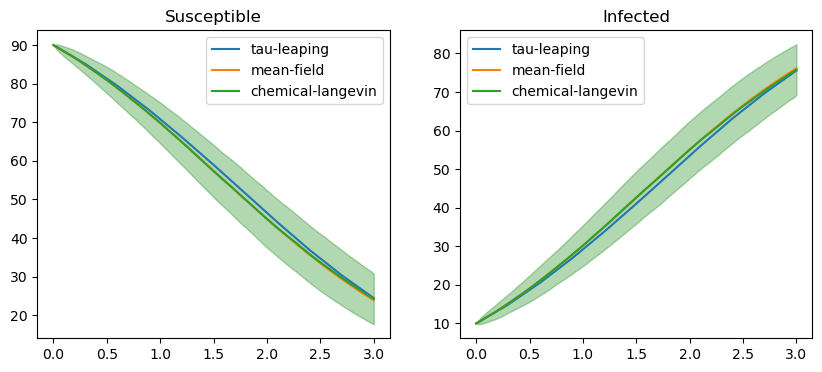

In [35]:
tcl = np.linspace(0,T, 10)
Xcl = []
for i in range(1000):
    Xcl.append(euler_maruyama(drift,S_matrix,c,X0,tmf))

Xcl_mean = np.mean(np.array(Xcl), axis=0)
std_xcl = np.std(np.array(Xcl), axis=0)

fig, axs = plt.subplots(1,2, figsize=(10,4))

axs[0].plot(t_tau, Xs, label='tau-leaping')
axs[0].plot(tmf, Xmf[:,0], label='mean-field')
axs[0].plot(tmf, Xcl_mean[:,0], label='chemical-langevin')
axs[0].fill_between(tmf, Xcl_mean[:,0]-std_xcl[:,0], Xcl_mean[:,0]+std_xcl[:,0] ,alpha=0.3, color='green')
axs[0].set_title('Susceptible')
axs[0].legend()

axs[1].plot(t_tau, Xi, label='tau-leaping')
axs[1].plot(tmf, Xmf[:,1], label='mean-field')
axs[1].plot(tmf, Xcl_mean[:,1], label='chemical-langevin')
axs[1].fill_between(tmf, Xcl_mean[:,1]-std_xcl[:,1], Xcl_mean[:,1]+std_xcl[:,1] ,alpha=0.3, color='green')
axs[1].set_title('Infected')
axs[1].legend()

Text(0, 0.5, 'Number of individuals')

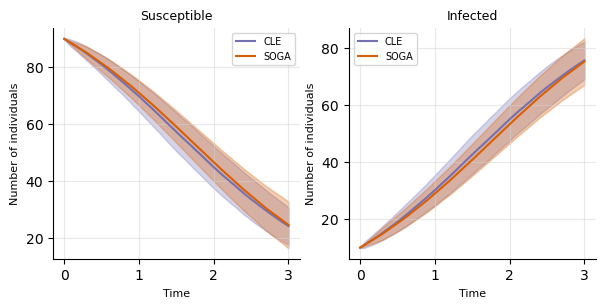

In [36]:
# Plot

fig, axs = plt.subplots(1,2, figsize=(7,3))

axs[0].plot(tmf, Xcl_mean[:,0], label='CLE', color=colors[2])
axs[0].fill_between(tmf, Xcl_mean[:,0]-std_xcl[:,0], Xcl_mean[:,0]+std_xcl[:,0] ,alpha=0.3,color=colors[2])
axs[0].plot(t_tau, xs, label='SOGA', color=colors[1])
axs[0].fill_between(t_tau, xs-stds, xs+stds ,alpha=0.3, color=colors[1])
axs[0].set_title('Susceptible', fontsize=9)
axs[0].legend(fontsize = 7)
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)
axs[0].grid(color='lightgray', alpha=0.5, zorder=1)
axs[0].set_xlabel('Time', fontsize=8)
axs[0].set_ylabel('Number of individuals', fontsize=8)

axs[1].plot(tmf, Xcl_mean[:,1], label='CLE', color=colors[2])
axs[1].fill_between(tmf, Xcl_mean[:,1]-std_xcl[:,1], Xcl_mean[:,1]+std_xcl[:,1] ,alpha=0.3, color=colors[2])
axs[1].plot(t_tau, xi, label='SOGA', color=colors[1])
axs[1].fill_between(t_tau, xi-stdi, xi+stdi ,alpha=0.3, color=colors[1])
axs[1].set_title('Infected', fontsize=9)
axs[1].legend(fontsize = 7)
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].grid(color='lightgray', alpha=0.5, zorder=1)
axs[1].set_xlabel('Time', fontsize=8)
axs[1].set_ylabel('Number of individuals', fontsize=8)

## Linear Noise

In [37]:
X, Sigma = linear_noise(drift,jac,S_matrix,c,X0,tmf)

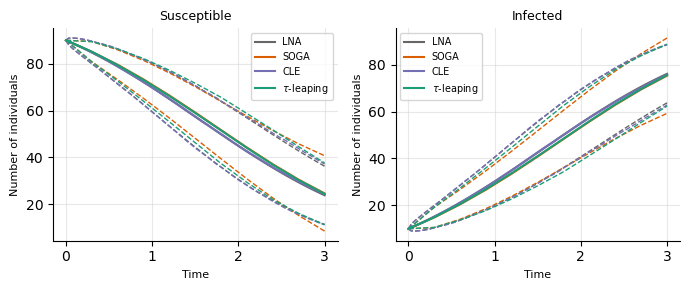

In [38]:
# Plot

fig, axs = plt.subplots(1,2, figsize=(7,3))

axs[0].plot(tmf, X[:,0], label='LNA', color=colors[7])
#axs[0].fill_between(tmf, X[:,0]-np.sqrt(Sigma[:,0,0]), X[:,0]+np.sqrt(Sigma[:,0,0]) ,alpha=0.3,color=colors[7])
axs[0].plot(tmf, X[:,0]-np.sqrt(Sigma[:,0,0])*1.96 ,'--',color=colors[7], linewidth=1)
axs[0].plot(tmf, X[:,0]+np.sqrt(Sigma[:,0,0])*1.96 ,'--',color=colors[7], linewidth=1)

axs[0].plot(t_tau, xs, label='SOGA', color=colors[1])
#axs[0].fill_between(t_tau, xs-stds, xs+stds ,alpha=0.3, color=colors[1])
axs[0].plot(t_tau, xs-stds*1.96 ,'--',color=colors[1], linewidth=1)
axs[0].plot(t_tau, xs+stds*1.96 ,'--',color=colors[1], linewidth=1)

axs[0].plot(tmf, Xcl_mean[:,0], label='CLE', color=colors[2])
#axs[0].fill_between(tmf, Xcl_mean[:,0]-std_xcl[:,0], Xcl_mean[:,0]+std_xcl[:,0] ,alpha=0.3,color=colors[2])
axs[0].plot(tmf, Xcl_mean[:,0]-std_xcl[:,0]*1.96 ,'--',color=colors[2], linewidth=1)
axs[0].plot(tmf, Xcl_mean[:,0]+std_xcl[:,0]*1.96 ,'--',color=colors[2], linewidth=1)

axs[0].plot(t_tau, Xs, label=r'$\tau$-leaping', color=colors[0])
#axs[0].fill_between(t_tau, Xs-stdS, Xs+stdS ,alpha=0.3, color=colors[0])
axs[0].plot(t_tau, Xs-stdS*1.96 ,'--',color=colors[0], linewidth=1)
axs[0].plot(t_tau, Xs+stdS*1.96 ,'--',color=colors[0], linewidth=1)

axs[0].set_title('Susceptible', fontsize=9)
axs[0].legend(fontsize = 7)
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)
axs[0].grid(color='lightgray', alpha=0.5, zorder=1)
axs[0].set_xlabel('Time', fontsize=8)
axs[0].set_ylabel('Number of individuals', fontsize=8)

axs[1].plot(tmf, X[:,1], label='LNA', color=colors[7])
#axs[1].fill_between(tmf, X[:,1]-np.sqrt(Sigma[:,1,1]), X[:,1]+np.sqrt(Sigma[:,1,1]) ,alpha=0.3,color=colors[7])
axs[1].plot(tmf, X[:,1]-np.sqrt(Sigma[:,1,1])*1.96 ,'--',color=colors[7], linewidth=1)
axs[1].plot(tmf, X[:,1]+np.sqrt(Sigma[:,1,1])*1.96 ,'--',color=colors[7], linewidth=1)

axs[1].plot(t_tau, xi, label='SOGA', color=colors[1])
#axs[1].fill_between(t_tau, xi-stdi, xi+stdi ,alpha=0.3, color=colors[1])
axs[1].plot(t_tau, xi-stdi*1.96 ,'--',color=colors[1], linewidth=1)
axs[1].plot(t_tau, xi+stdi*1.96 ,'--',color=colors[1], linewidth=1)

axs[1].plot(tmf, Xcl_mean[:,1], label='CLE', color=colors[2])
#axs[1].fill_between(tmf, Xcl_mean[:,1]-std_xcl[:,1], Xcl_mean[:,1]+std_xcl[:,1] ,alpha=0.3, color=colors[2])
axs[1].plot(tmf, Xcl_mean[:,1]-std_xcl[:,1]*1.96 ,'--',color=colors[2], linewidth=1)
axs[1].plot(tmf, Xcl_mean[:,1]+std_xcl[:,1]*1.96 ,'--',color=colors[2], linewidth=1)

axs[1].plot(t_tau, Xi, label=r'$\tau$-leaping', color = colors[0])
#axs[1].fill_between(t_tau, Xi-stdI, Xi+stdI, alpha=0.3, color=colors[0])
axs[1].plot(t_tau, Xi-stdI*1.96 ,'--',color=colors[0], linewidth=1)
axs[1].plot(t_tau, Xi+stdI*1.96 ,'--',color=colors[0], linewidth=1)

axs[1].set_title('Infected', fontsize=9)
axs[1].legend(fontsize = 7)
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].grid(color='lightgray', alpha=0.5, zorder=1)
axs[1].set_xlabel('Time', fontsize=8)
axs[1].set_ylabel('Number of individuals', fontsize=8)

plt.tight_layout()
plt.savefig('SI5mom1.png')

In [39]:
tau = 0.3  # Leap size
T = 12
n_runs = 1000
runs = []

for run in range(n_runs):
    if 100*run/n_runs % 10 == 0:
        print(100*run/n_runs, '% simulations completed')
    X = None
    while X is None:
        X, t_tau = tau_leaping(drift, S_matrix, c, X0, T, tau)
    runs.append(X)
    
print('Number of steps: ', len(X))

Xs = np.mean(np.array(runs)[:,:,0], axis=0)
Xi = np.mean(np.array(runs)[:,:,1], axis=0)

stdS = np.std(np.array(runs)[:,:,0], axis=0)
stdI = np.std(np.array(runs)[:,:,1], axis=0)

0.0 % simulations completed
Negative population, restarting run
Negative population, restarting run
Negative population, restarting run
Negative population, restarting run
Negative population, restarting run
Negative population, restarting run
Negative population, restarting run
Negative population, restarting run
Negative population, restarting run
Negative population, restarting run
Negative population, restarting run
Negative population, restarting run
Negative population, restarting run
Negative population, restarting run
Negative population, restarting run
Negative population, restarting run
Negative population, restarting run
Negative population, restarting run
Negative population, restarting run
Negative population, restarting run
Negative population, restarting run
10.0 % simulations completed
Negative population, restarting run
Negative population, restarting run
Negative population, restarting run
Negative population, restarting run
Negative population, restarting run
Negativ

In [40]:
compiledFile=compile2SOGA('../programs/SOGA/SSA/SI5mom1_longer.soga')
cfg = produce_cfg(compiledFile)
start = time()
output_dist = start_SOGA(cfg, pruning='ranking')
end = time()

print('Computed in {}s'.format(np.round(end-start,3)))

t = len(t_tau)

xs_l = np.zeros(t)
xi_l = np.zeros(t)
stds_l = np.zeros(t)
stdi_l = np.zeros(t)

for i in range(t):
    idxs_l = output_dist.var_list.index('susceptible[{}]'.format(i))
    idxi_l = output_dist.var_list.index('infected[{}]'.format(i))
    xs_l[i] = output_dist.gm.mean()[idxs_l]
    stds_l[i] = np.sqrt(output_dist.gm.cov()[idxs_l,idxs_l])
    xi_l[i] = output_dist.gm.mean()[idxi_l]
    stdi_l[i] = np.sqrt(output_dist.gm.cov()[idxi_l,idxi_l])

ANTLR runtime and generated code versions disagree: 4.13.1!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.1!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.1!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.1!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.1!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.1!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.1!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.1!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.1!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.1!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.1!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.1!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.1!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.1!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.1!=4.

In [41]:
compiledFile=compile2SOGA('../programs/SOGA/SSA/SI5mom1_observe.soga')
cfg = produce_cfg(compiledFile)
start = time()
output_dist = start_SOGA(cfg, pruning='ranking')
end = time()

print('Computed in {}s'.format(np.round(end-start,3)))

t = len(t_tau)

xs_o = np.zeros(t)
xi_o = np.zeros(t)
stds_o = np.zeros(t)
stdi_o = np.zeros(t)

for i in range(t):
    idxs_o = output_dist.var_list.index('susceptible[{}]'.format(i))
    idxi_o = output_dist.var_list.index('infected[{}]'.format(i))
    xs_o[i] = output_dist.gm.mean()[idxs_o]
    stds_o[i] = np.sqrt(output_dist.gm.cov()[idxs_o,idxs_o])
    xi_o[i] = output_dist.gm.mean()[idxi_o]
    stdi_o[i] = np.sqrt(output_dist.gm.cov()[idxi_o,idxi_o])

ANTLR runtime and generated code versions disagree: 4.13.1!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.1!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.1!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.1!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.1!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.1!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.1!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.1!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.1!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.1!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.1!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.1!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.1!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.1!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.1!=4.

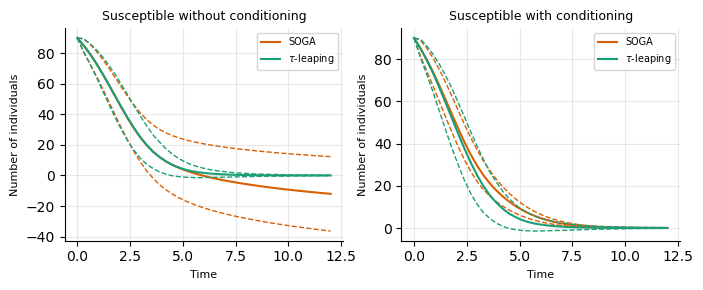

In [42]:
# Plot

fig, axs = plt.subplots(1,2, figsize=(7,3))

axs[0].plot(t_tau, xs_l, label='SOGA', color=colors[1])
#axs[0].fill_between(t_tau, xs-stds, xs+stds ,alpha=0.3, color=colors[1])
axs[0].plot(t_tau, xs_l-stds_l*1.96 ,'--',color=colors[1], linewidth=1)
axs[0].plot(t_tau, xs_l+stds_l*1.96 ,'--',color=colors[1], linewidth=1)

axs[0].plot(t_tau, Xs, label=r'$\tau$-leaping', color=colors[0])
#axs[0].fill_between(t_tau, Xs-stdS, Xs+stdS ,alpha=0.3, color=colors[0])
axs[0].plot(t_tau, Xs-stdS*1.96 ,'--',color=colors[0], linewidth=1)
axs[0].plot(t_tau, Xs+stdS*1.96 ,'--',color=colors[0], linewidth=1)

axs[0].set_title('Susceptible without conditioning', fontsize=9)
axs[0].legend(fontsize = 7)
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)
axs[0].grid(color='lightgray', alpha=0.5, zorder=1)
axs[0].set_xlabel('Time', fontsize=8)
axs[0].set_ylabel('Number of individuals', fontsize=8)

axs[1].plot(t_tau, xs_o, label='SOGA', color=colors[1])
#axs[0].fill_between(t_tau, xs-stds, xs+stds ,alpha=0.3, color=colors[1])
axs[1].plot(t_tau, xs_o-stds_o*1.96 ,'--',color=colors[1], linewidth=1)
axs[1].plot(t_tau, xs_o+stds_o*1.96 ,'--',color=colors[1], linewidth=1)

axs[1].plot(t_tau, Xs, label=r'$\tau$-leaping', color=colors[0])
#axs[0].fill_between(t_tau, Xs-stdS, Xs+stdS ,alpha=0.3, color=colors[0])
axs[1].plot(t_tau, Xs-stdS*1.96 ,'--',color=colors[0], linewidth=1)
axs[1].plot(t_tau, Xs+stdS*1.96 ,'--',color=colors[0], linewidth=1)

axs[1].set_title('Susceptible with conditioning', fontsize=9)
axs[1].legend(fontsize = 7)
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].grid(color='lightgray', alpha=0.5, zorder=1)
axs[1].set_xlabel('Time', fontsize=8)
axs[1].set_ylabel('Number of individuals', fontsize=8)

plt.tight_layout()
plt.savefig('conditioning.png')

#FINO a 10 e comparare con TAU LEAPING